In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
from typing import List

import pandas as pd
import tqdm

import dataflow.core as dtfcore
import dataflow.core.node as dtfcornode
import dataflow.core.nodes.sources as dtfconosou
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hpandas as hpandas
import helpers.hpickle as hpickle
import helpers.hprint as hprint
import research_amp.soccer_prediction.models as rasoprmo
import research_amp.soccer_prediction.preprocessing as rasoprpr

/app/amp/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

DEBUG Effective logging level=10
DEBUG Shut up 116 modules: matplotlib, matplotlib.gridspec, botocore.paginate, matplotlib.category, botocore.endpoint, matplotlib.textpath, botocore.utils, matplotlib.backend_bases, matplotlib.axes._axes, botocore.hooks, urllib3.util, botocore.httpchecksum, matplotlib._afm, botocore.loaders, fsspec, boto3.resources.base, matplotlib.font_manager, urllib3, matplotlib.texmanager, boto3.resources.factory, botocore.waiter, matplotlib._layoutgrid, urllib3.connection, botocore.credentials, botocore.parsers, matplotlib.ticker, boto3.resources, botocore.compress, matplotlib._constrained_layout, botocore.retries.standard, botocore.discovery, boto3.resources.model, botocore.response, matplotlib.style.core, matplotlib.style, botocore.args, s3fs, matplotlib.colorbar, botocore.endpoint_provider, botocore.retryhandler, botocore.httpsession, boto3.resources.action, urllib3.util.retry, botocore.compat, botocore.tokens, botocore.retries.adaptive, matplotlib.axes, matplot

# Config

In [4]:
amp_path = hgit.get_amp_abs_path()
params_file_path = os.path.join(
    amp_path, "research_amp", "soccer_prediction", "params.ENG5.2009_2012.pkl"
)
# Define the necessary preprocessing step configuration.
config = {
    "load_and_preprocess_node": {
        "bucket_name": "cryptokaizen-data-test",
        "dataset_path": "kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt",
        "leagues": ["ENG5"],
        "seasons": ["2009", "2010", "2011", "2012"],
    },
    "poisson_regressor": {
        "maxiter": None,
        "col_mode": None,
        "half_life_period": None,
    },
    "model_fit_config": {
        "fit_at_beginning": False,
        "train_intervals": [
            (
                pd.Timestamp("2009-08-08 00:00:00"),
                pd.Timestamp("2012-04-28 00:03:40"),
            )
        ],
        "params_file_path": params_file_path,
    },
    "model_predict_config": {
        "test_intervals": [
            (
                pd.Timestamp("2012-08-10 00:00:00"),
                pd.Timestamp("2013-04-20 00:03:40"),
            )
        ],
        "freq": "1W",
    },
}
display(config)

DEBUG > (git rev-parse --show-toplevel) 2>&1
DEBUG > (cd /app/amp; (git remote -v | grep origin | grep fetch)) 2>&1
DEBUG data=['origin', 'git@github.com:cryptokaizen/cmamp.git', '(fetch)']
DEBUG host_name=github.com repo_name=cryptokaizen/cmamp.git
DEBUG repo_sym_name=cryptokaizen/cmamp
DEBUG > (git rev-parse --show-toplevel) 2>&1


{'load_and_preprocess_node': {'bucket_name': 'cryptokaizen-data-test',
  'dataset_path': 'kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt',
  'leagues': ['ENG5'],
  'seasons': ['2009', '2010', '2011', '2012']},
 'poisson_regressor': {'maxiter': None,
  'col_mode': None,
  'half_life_period': None},
 'model_fit_config': {'fit_at_beginning': False,
  'train_intervals': [(Timestamp('2009-08-08 00:00:00'),
    Timestamp('2012-04-28 00:03:40'))],
  'params_file_path': '/app/amp/research_amp/soccer_prediction/params.ENG5.2009_2012.pkl'},
 'model_predict_config': {'test_intervals': [(Timestamp('2012-08-10 00:00:00'),
    Timestamp('2013-04-20 00:03:40'))],
  'freq': '1W'}}

# Build the DAG

## Source Node

In [5]:
node_1 = "load_and_preprocess_node"
# Initialize the FunctionDataSource with the correct configuration.
load_and_preprocess_node = dtfconosou.FunctionDataSource(
    node_1, func=rasoprpr.load_and_preprocess_data, func_kwargs=config[node_1]
)
# Display the data.
soccer_data = load_and_preprocess_node.fit()["df_out"]
_LOG.info(hpandas.df_to_str(soccer_data))

DEBUG Getting credentials for aws_profile='ck'
DEBUG Using AWS credentials from files
DEBUG config.sections=['am', 'ck']
DEBUG config.sections=['profile am', 'profile ck']
INFO  Loading kaizen_ai/soccer_prediction/datasets/OSF_football/ISDBv2.txt from bucket cryptokaizen-data-test
INFO  Data Loaded into Memory.


,season,league,Date,home_team,opponent,goals_scored_by_home_team,goals_scored_by_opponent,goal_difference,match_outcome,home_team_id,opponent_id
2009-08-08 00:00:00,09-10,ENG5,2009-08-08 00:00:00,AFC Wimbledon,Luton Town,1,1,0,draw,0,18
2009-08-08 00:00:20,09-10,ENG5,2009-08-08 00:00:00,Altrincham,Ebbsfleet,1,1,0,draw,1,14
2009-08-08 00:00:40,09-10,ENG5,2009-08-08 00:00:00,Cambridge,Barrow,0,2,-2,loss,2,12
,...,...,...,...,...,...,...,...,...,...,...
2013-04-20 00:03:00,12-13,ENG5,2013-04-20 00:00:00,Hyde United,Lincoln,1,5,-4,loss,37,31
2013-04-20 00:03:20,12-13,ENG5,2013-04-20 00:00:00,Grimsby,Newport County,3,0,3,win,27,28
2013-04-20 00:03:40,12-13,ENG5,2013-04-20 00:00:00,Tamworth,Woking,2,1,1,win,21,39


INFO  None


## Poisson Node

In [6]:
# Define node ID and variables.
node_3 = dtfcornode.NodeId("poisson_regressor")
# Instantiate the poisson model.
poisson_model_node = rasoprmo.BivariatePoissonModel(nid=node_3, **config[node_3])

## Connect the Nodes

In [7]:
name = "soccer_prediction"
dag = dtfcore.DAG(name=name, mode="loose")
# Add nodes to the DAG.
dag.insert_at_head(load_and_preprocess_node)
dag.append_to_tail(poisson_model_node)
_LOG.info("DAG=\n%s", repr(dag))

DEBUG name='soccer_prediction', mode='loose'
DEBUG save_node_io='', save_node_df_out_stats=False, profile_execution=False, dst_dir=None
INFO  DAG=
<dataflow.core.dag.DAG at 0x7f7237c93bb0>:
  _nx_dag='DiGraph with 2 nodes and 1 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='loose' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[('load_and_preprocess_node', {'stage': <dataflow.core.nodes.sources.FunctionDataSource object at 0x7f7233094940>}), ('poisson_regressor', {'stage': <research_amp.soccer_prediction.models.BivariatePoissonModel object at 0x7f72375bf700>})]
  edges=[('load_and_preprocess_node', 'poisson_regressor', {'df_in': 'df_out'})]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [
          {
              "df_in": "df_out",
              "source": "load_and_preprocess_node",
            

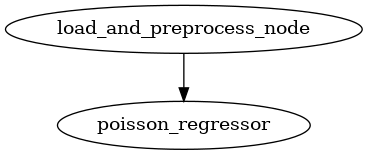

In [8]:
# Draw the DAG.
dtfcore.draw(dag)

# Run the DAG

## Fit

In [9]:
if config["model_fit_config"]["fit_at_beginning"]:
    # Estimate the params and save them to disk.
    # Use `FitPredictDagRunner` to learn the parameters.
    fit_predict_dag_runner = dtfcore.FitPredictDagRunner(dag)
    # Define train time interval.
    # train_intervals = [(pd.Timestamp("2000-03-19 00:00:00"), pd.Timestamp("2000-08-26 00:03:20"))]
    fit_predict_dag_runner.set_fit_intervals(
        config["model_fit_config"]["train_intervals"]
    )
    #
    fit_predict_dag_runner.fit()
    fit_state = dtfcore.get_fit_state(dag)
    # Save params to disk.
    hpickle.to_pickle(fit_state, config["model_fit_config"]["params_file_path"])
else:
    # Load params from disk.
    fit_state = hpickle.from_pickle(
        config["model_fit_config"]["params_file_path"]
    )
_LOG.info("Fit_state=\n%s", fit_state)

DEBUG Unpickling from '/app/amp/research_amp/soccer_prediction/params.ENG5.2009_2012.pkl' ...
DEBUG Unpickling from '/app/amp/research_amp/soccer_prediction/params.ENG5.2009_2012.pkl' done (0.001 s)
DEBUG Read '/app/amp/research_amp/soccer_prediction/params.ENG5.2009_2012.pkl' (size=23.6 KB, time=0.0s)
INFO  Fit_state=
OrderedDict([('load_and_preprocess_node', {}), ('poisson_regressor', {'params': [array([ 2.95554890e-01,  1.19890780e-01,  1.00000000e+00,  4.85345062e-03,
        7.59315050e-04,  5.97056514e-03,  1.12569415e-02,  1.30019319e-02,
        2.16718436e-02,  2.72140273e-02,  4.28872221e-04,  3.43363163e-03,
        1.09879193e-03,  2.24489905e-02,  7.29853487e-03,  7.02551374e-03,
        1.51123199e-03,  1.24480735e-02,  6.46938313e-03,  5.33318257e-04,
       -1.90969380e-03,  2.06417978e-02,  1.66730120e-02, -1.05403973e-03,
        2.51699315e-04, -3.36023221e-04,  1.44627950e-02,  2.91140145e-03,
        1.45050205e-03,  3.10395406e-02,  1.90983376e-02,  7.25454612e-03

## Predict

In [10]:
# TODO(Grisha): consider moving to `IncrementalDagRunner`.
def concatenate_results(
    result_bundles: List[dtfcore.ResultBundle],
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
    freq: str,
) -> pd.DataFrame:
    """
    Concatenate results from multiple iterations into a single dataframe.

    On each iteration we collect only "new" predictions, i.e. the ones
    that were not computed during the previous iteration.
    """
    predictions = []
    for i in tqdm.tqdm(range(len(result_bundles))):
        # For each results bundle collect resulting df.
        df = result_bundles[i].result_df
        # Restrict date range to test start/end timestamps.
        df = df.loc[start_timestamp:end_timestamp]
        # For each iteration keep only the "new" prediction, i.e. the ones that correspond
        # to a given freq.
        iteration_start_timestamp = df.index.max() - pd.Timedelta(freq)
        _LOG.info(
            "Min date=%s, max date=%s", iteration_start_timestamp, df.index.max()
        )
        current_df = df.loc[iteration_start_timestamp:]
        predictions.append(current_df)
        _LOG.info(hpandas.df_to_str(current_df))
    return pd.concat(predictions)

In [11]:
# Set test intervals.
# test_intervals = [(pd.Timestamp("2000-08-26 00:03:40"), pd.Timestamp("2000-08-31 00:04:00"))]
# Set prediction frequency.
freq = "1W"
incremental_dag_runner = dtfcore.IncrementalDagRunner(
    dag,
    config["model_predict_config"]["test_intervals"][0][0],
    config["model_predict_config"]["test_intervals"][0][1],
    config["model_predict_config"]["freq"],
    fit_state,
)
result_bundles = list(incremental_dag_runner.predict())

DEBUG _result_nid=poisson_regressor


run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.015 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.014 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.023 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.030 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.019 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.027 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.019 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.020 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.019 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.026 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.016 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.015 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.029 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.014 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.012 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.030 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.015 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.012 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.012 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.014 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.012 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.013 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.028 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date      home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                 

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

DEBUG Executing node 'load_and_preprocess_node'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=0 nid='load_and_preprocess_node' ...
################################################################################
DEBUG kwargs are {}
DEBUG node_execution ...
DEBUG node_execution done (0.018 s)
DEBUG Executing node 'poisson_regressor'
DEBUG 
################################################################################
Executing method 'predict' for node topological_id=1 nid='poisson_regressor' ...
################################################################################
DEBUG pred_nid=load_and_preprocess_node, nid=poisson_regressor
DEBUG kwargs are {'df_in':                     season league       Date       home_team        opponent  goals_scored_by_home_team  goals_scored_by_opponent  goal_difference match_outcome  home_team_id  opponent_id
Adjusted_Date                                

In [12]:
predictions_df = concatenate_results(
    result_bundles,
    config["model_predict_config"]["test_intervals"][0][0],
    config["model_predict_config"]["test_intervals"][0][1],
    config["model_predict_config"]["freq"],
)

  0%|                                                                                                                                                                              | 0/36 [00:00<?, ?it/s]

INFO  Min date=2012-08-04 00:03:20, max date=2012-08-11 00:03:20


,prob_win,prob_loss,prob_draw
2012-08-10 00:00:00,0.446479,0.299625,0.253891
2012-08-11 00:00:00,0.485369,0.259657,0.254969
2012-08-11 00:00:20,0.495133,0.228853,0.276012
,...,...,...
2012-08-11 00:02:40,0.43185,0.315227,0.252918
2012-08-11 00:03:00,0.607682,0.188765,0.203477
2012-08-11 00:03:20,0.518848,0.255873,0.225251


INFO  None
INFO  Min date=2012-08-11 00:03:20, max date=2012-08-18 00:03:20


,prob_win,prob_loss,prob_draw
2012-08-11 00:03:20,0.518848,0.255873,0.225251
2012-08-14 00:00:00,0.321549,0.394455,0.283996
2012-08-14 00:00:20,0.434302,0.320705,0.244985
,...,...,...
2012-08-18 00:02:40,0.343638,0.373645,0.282716
2012-08-18 00:03:00,0.470752,0.27256,0.256683
2012-08-18 00:03:20,0.421217,0.314927,0.263853


INFO  None
INFO  Min date=2012-08-18 00:03:20, max date=2012-08-25 00:03:20


,prob_win,prob_loss,prob_draw
2012-08-18 00:03:20,0.421217,0.314927,0.263853
2012-08-24 00:00:00,0.429487,0.31796,0.252548
2012-08-25 00:00:00,0.453148,0.294995,0.251851
,...,...,...
2012-08-25 00:02:40,0.562121,0.196803,0.241065
2012-08-25 00:03:00,0.489865,0.290686,0.219408
2012-08-25 00:03:20,0.586494,0.207787,0.205643


INFO  None
INFO  Min date=2012-08-25 00:03:40, max date=2012-09-01 00:03:40


,prob_win,prob_loss,prob_draw
2012-08-27 00:00:00,0.472551,0.279495,0.247947
2012-08-27 00:00:20,0.327263,0.38623,0.286506
2012-08-27 00:00:40,0.463797,0.287658,0.248539
,...,...,...
2012-09-01 00:03:00,0.475983,0.265663,0.25835
2012-09-01 00:03:20,0.571112,0.210562,0.218289
2012-09-01 00:03:40,0.533607,0.241195,0.22517


INFO  None
INFO  Min date=2012-09-01 00:03:40, max date=2012-09-08 00:03:40


,prob_win,prob_loss,prob_draw
2012-09-01 00:03:40,0.533607,0.241195,0.22517
2012-09-04 00:00:00,0.446479,0.299625,0.253891
2012-09-04 00:00:20,0.355561,0.394249,0.250185
,...,...,...
2012-09-08 00:03:00,0.364199,0.345583,0.290217
2012-09-08 00:03:20,0.446479,0.299625,0.253891
2012-09-08 00:03:40,0.446479,0.299625,0.253891


INFO  None
INFO  Min date=2012-09-08 00:03:40, max date=2012-09-15 00:03:40


,prob_win,prob_loss,prob_draw
2012-09-08 00:03:40,0.446479,0.299625,0.253891
2012-09-15 00:00:00,0.5407,0.2087,0.250592
2012-09-15 00:00:20,0.484965,0.294242,0.220755
,...,...,...
2012-09-15 00:03:00,0.456741,0.305117,0.23813
2012-09-15 00:03:20,0.443887,0.301432,0.254677
2012-09-15 00:03:40,0.438862,0.304947,0.256187


INFO  None


 17%|███████████████████████████▋                                                                                                                                          | 6/36 [00:00<00:00, 53.77it/s]

INFO  Min date=2012-09-15 00:03:20, max date=2012-09-22 00:03:20


,prob_win,prob_loss,prob_draw
2012-09-15 00:03:20,0.443887,0.301432,0.254677
2012-09-15 00:03:40,0.438862,0.304947,0.256187
2012-09-21 00:00:00,0.466578,0.30876,0.224632
,...,...,...
2012-09-22 00:02:40,0.549635,0.230913,0.219414
2012-09-22 00:03:00,0.387421,0.355915,0.25666
2012-09-22 00:03:20,0.478612,0.263976,0.257408


INFO  None
INFO  Min date=2012-09-22 00:03:20, max date=2012-09-29 00:03:20


,prob_win,prob_loss,prob_draw
2012-09-22 00:03:20,0.478612,0.263976,0.257408
2012-09-25 00:00:00,0.514609,0.258709,0.226655
2012-09-25 00:00:20,0.344632,0.361587,0.29378
,...,...,...
2012-09-29 00:02:40,0.412829,0.337457,0.249708
2012-09-29 00:03:00,0.519611,0.220607,0.259777
2012-09-29 00:03:20,0.415609,0.342291,0.242091


INFO  None
INFO  Min date=2012-09-29 00:03:40, max date=2012-10-06 00:03:40


,prob_win,prob_loss,prob_draw
2012-10-06 00:00:00,0.421003,0.346278,0.232703
2012-10-06 00:00:20,0.448285,0.297583,0.254128
2012-10-06 00:00:40,0.529369,0.243937,0.226668
,...,...,...
2012-10-06 00:03:00,0.432058,0.316104,0.251832
2012-10-06 00:03:20,0.488463,0.270921,0.240604
2012-10-06 00:03:40,0.434425,0.313379,0.252191


INFO  None
INFO  Min date=2012-10-06 00:03:40, max date=2012-10-13 00:03:40


,prob_win,prob_loss,prob_draw
2012-10-06 00:03:40,0.434425,0.313379,0.252191
2012-10-09 00:00:00,0.405461,0.354219,0.24031
2012-10-09 00:00:20,0.383174,0.359182,0.25764
,...,...,...
2012-10-13 00:03:00,0.417261,0.333326,0.249407
2012-10-13 00:03:20,0.555026,0.225748,0.219188
2012-10-13 00:03:40,0.533607,0.241195,0.22517


INFO  None
INFO  Min date=2012-10-06 00:03:40, max date=2012-10-13 00:03:40


,prob_win,prob_loss,prob_draw
2012-10-06 00:03:40,0.434425,0.313379,0.252191
2012-10-09 00:00:00,0.405461,0.354219,0.24031
2012-10-09 00:00:20,0.383174,0.359182,0.25764
,...,...,...
2012-10-13 00:03:00,0.417261,0.333326,0.249407
2012-10-13 00:03:20,0.555026,0.225748,0.219188
2012-10-13 00:03:40,0.533607,0.241195,0.22517


INFO  None
INFO  Min date=2012-10-20 00:03:00, max date=2012-10-27 00:03:00


,prob_win,prob_loss,prob_draw
2012-10-26 00:00:00,0.348805,0.417231,0.233949
2012-10-27 00:00:00,0.400407,0.332372,0.267219
2012-10-27 00:00:20,0.529981,0.248471,0.221513
,...,...,...
2012-10-27 00:02:20,0.314001,0.415384,0.270613
2012-10-27 00:02:40,0.470752,0.27256,0.256683
2012-10-27 00:03:00,0.44066,0.302886,0.25645


INFO  None
INFO  Min date=2012-10-27 00:00:20, max date=2012-11-03 00:00:20


,prob_win,prob_loss,prob_draw
2012-10-27 00:00:20,0.529981,0.248471,0.221513
2012-10-27 00:00:40,0.548804,0.1992,0.25199
2012-10-27 00:01:00,0.392215,0.365885,0.241891
,...,...,...
2012-10-27 00:03:00,0.44066,0.302886,0.25645
2012-11-03 00:00:00,0.467198,0.285329,0.247466
2012-11-03 00:00:20,0.290474,0.449644,0.259879


INFO  None


 36%|███████████████████████████████████████████████████████████▌                                                                                                         | 13/36 [00:00<00:00, 59.89it/s]

INFO  Min date=2012-11-03 00:03:20, max date=2012-11-10 00:03:20


,prob_win,prob_loss,prob_draw
2012-11-06 00:00:00,0.298357,0.428447,0.273194
2012-11-06 00:00:20,0.391418,0.361033,0.247542
2012-11-06 00:00:40,0.441836,0.304898,0.253261
,...,...,...
2012-11-10 00:02:40,0.420808,0.271927,0.307264
2012-11-10 00:03:00,0.45496,0.292969,0.252066
2012-11-10 00:03:20,0.529369,0.243937,0.226668


INFO  None
INFO  Min date=2012-11-11 00:00:00, max date=2012-11-18 00:00:00


,prob_win,prob_loss,prob_draw
2012-11-17 00:00:00,0.471921,0.248256,0.279822
2012-11-17 00:00:20,0.417261,0.333326,0.249407
2012-11-17 00:00:40,0.438862,0.304947,0.256187
,...,...,...
2012-11-17 00:03:00,0.416011,0.321129,0.262857
2012-11-17 00:03:20,0.266372,0.476999,0.256624
2012-11-18 00:00:00,0.52387,0.267319,0.208731


INFO  None
INFO  Min date=2012-11-13 00:00:40, max date=2012-11-20 00:00:40


,prob_win,prob_loss,prob_draw
2012-11-17 00:00:00,0.471921,0.248256,0.279822
2012-11-17 00:00:20,0.417261,0.333326,0.249407
2012-11-17 00:00:40,0.438862,0.304947,0.256187
,...,...,...
2012-11-20 00:00:00,0.440661,0.33231,0.227005
2012-11-20 00:00:20,0.434425,0.313379,0.252191
2012-11-20 00:00:40,0.348805,0.417231,0.233949


INFO  None
INFO  Min date=2012-11-24 00:02:00, max date=2012-12-01 00:02:00


,prob_win,prob_loss,prob_draw
2012-12-01 00:00:00,0.446479,0.299625,0.253891
2012-12-01 00:00:20,0.432079,0.333644,0.234261
2012-12-01 00:00:40,0.401882,0.338165,0.25995
,...,...,...
2012-12-01 00:01:20,0.414715,0.335229,0.25005
2012-12-01 00:01:40,0.341998,0.375915,0.282086
2012-12-01 00:02:00,0.470005,0.310036,0.21992


INFO  None
INFO  Min date=2012-12-01 00:03:20, max date=2012-12-08 00:03:20


,prob_win,prob_loss,prob_draw
2012-12-04 00:00:00,0.347368,0.357754,0.294878
2012-12-04 00:00:20,0.523712,0.235604,0.240673
2012-12-04 00:00:40,0.438862,0.304947,0.256187
,...,...,...
2012-12-08 00:02:40,0.56623,0.213521,0.220214
2012-12-08 00:03:00,0.439731,0.324023,0.236232
2012-12-08 00:03:20,0.448285,0.297583,0.254128


INFO  None
INFO  Min date=2012-12-08 00:00:00, max date=2012-12-15 00:00:00


,prob_win,prob_loss,prob_draw
2012-12-08 00:00:00,0.602687,0.174808,0.22248
2012-12-08 00:00:20,0.453148,0.294995,0.251851
2012-12-08 00:00:40,0.531157,0.208818,0.26002
,...,...,...
2012-12-08 00:03:20,0.448285,0.297583,0.254128
2012-12-11 00:00:00,0.356818,0.394548,0.248629
2012-12-15 00:00:00,0.446479,0.299625,0.253891


INFO  None
INFO  Min date=2012-12-15 00:00:00, max date=2012-12-22 00:00:00


,prob_win,prob_loss,prob_draw
Adjusted_Date,,,
2012-12-15 00:00:00,0.446479,0.299625,0.253891
2012-12-18 00:00:00,0.496136,0.252825,0.251032
2012-12-18 00:00:20,0.510261,0.258125,0.231595
2012-12-21 00:00:00,0.454790,0.321510,0.223669
2012-12-22 00:00:00,0.544730,0.234045,0.221191


INFO  None


 56%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 20/36 [00:00<00:00, 57.73it/s]

INFO  Min date=2012-12-22 00:01:20, max date=2012-12-29 00:01:20


,prob_win,prob_loss,prob_draw
2012-12-26 00:00:00,0.378055,0.380516,0.24142
2012-12-26 00:00:20,0.381469,0.373219,0.245304
2012-12-26 00:00:40,0.39758,0.34136,0.261057
,...,...,...
2012-12-29 00:00:40,0.488463,0.270921,0.240604
2012-12-29 00:01:00,0.5285,0.210277,0.261218
2012-12-29 00:01:20,0.622476,0.164329,0.213157


INFO  None
INFO  Min date=2012-12-29 00:02:20, max date=2013-01-05 00:02:20


,prob_win,prob_loss,prob_draw
2013-01-01 00:00:00,0.49118,0.2691,0.239709
2013-01-01 00:00:20,0.263477,0.481492,0.255025
2013-01-01 00:00:40,0.534773,0.2386,0.226601
,...,...,...
2013-01-05 00:01:40,0.441836,0.304898,0.253261
2013-01-05 00:02:00,0.299287,0.43669,0.26402
2013-01-05 00:02:20,0.529369,0.243937,0.226668


INFO  None
INFO  Min date=2013-01-06 00:00:00, max date=2013-01-13 00:00:00


,prob_win,prob_loss,prob_draw
2013-01-08 00:00:00,0.531157,0.208818,0.26002
2013-01-08 00:00:20,0.515,0.253308,0.231672
2013-01-08 00:00:40,0.49385,0.265251,0.240888
,...,...,...
2013-01-12 00:01:00,0.515621,0.275526,0.208773
2013-01-12 00:01:20,0.441836,0.304898,0.253261
2013-01-13 00:00:00,0.415371,0.335549,0.249074


INFO  None
INFO  Min date=2013-01-12 00:01:20, max date=2013-01-19 00:01:20


,prob_win,prob_loss,prob_draw
2013-01-12 00:01:20,0.441836,0.304898,0.253261
2013-01-13 00:00:00,0.415371,0.335549,0.249074
2013-01-15 00:00:00,0.272957,0.46684,0.260199
,...,...,...
2013-01-19 00:00:40,0.315012,0.403936,0.281051
2013-01-19 00:01:00,0.43925,0.306721,0.254024
2013-01-19 00:01:20,0.439871,0.293039,0.267088


INFO  None
INFO  Min date=2013-01-19 00:00:40, max date=2013-01-26 00:00:40


,prob_win,prob_loss,prob_draw
2013-01-19 00:00:40,0.315012,0.403936,0.281051
2013-01-19 00:01:00,0.43925,0.306721,0.254024
2013-01-19 00:01:20,0.439871,0.293039,0.267088
,...,...,...
2013-01-26 00:00:00,0.344924,0.403043,0.252027
2013-01-26 00:00:20,0.434239,0.310267,0.25549
2013-01-26 00:00:40,0.398788,0.355277,0.245928


INFO  None
INFO  Min date=2013-01-26 00:02:40, max date=2013-02-02 00:02:40


,prob_win,prob_loss,prob_draw
2013-01-29 00:00:00,0.628956,0.157103,0.213907
2013-01-29 00:00:20,0.519635,0.260339,0.219987
2013-02-01 00:00:00,0.49118,0.2691,0.239709
,...,...,...
2013-02-02 00:02:00,0.443887,0.301432,0.254677
2013-02-02 00:02:20,0.446479,0.299625,0.253891
2013-02-02 00:02:40,0.417261,0.333326,0.249407


INFO  None


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 26/36 [00:00<00:00, 55.04it/s]

INFO  Min date=2013-02-02 00:03:40, max date=2013-02-09 00:03:40


,prob_win,prob_loss,prob_draw
2013-02-09 00:00:00,0.446479,0.299625,0.253891
2013-02-09 00:00:20,0.463797,0.287658,0.248539
2013-02-09 00:00:40,0.515,0.253308,0.231672
,...,...,...
2013-02-09 00:03:00,0.417261,0.333326,0.249407
2013-02-09 00:03:20,0.551471,0.229149,0.219341
2013-02-09 00:03:40,0.528867,0.245878,0.225227


INFO  None
INFO  Min date=2013-02-09 00:02:40, max date=2013-02-16 00:02:40


,prob_win,prob_loss,prob_draw
2013-02-09 00:02:40,0.488197,0.238706,0.273095
2013-02-09 00:03:00,0.417261,0.333326,0.249407
2013-02-09 00:03:20,0.551471,0.229149,0.219341
,...,...,...
2013-02-16 00:02:00,0.378055,0.380516,0.24142
2013-02-16 00:02:20,0.618413,0.17935,0.202161
2013-02-16 00:02:40,0.467715,0.275901,0.25638


INFO  None
INFO  Min date=2013-02-16 00:02:00, max date=2013-02-23 00:02:00


,prob_win,prob_loss,prob_draw
2013-02-16 00:02:00,0.378055,0.380516,0.24142
2013-02-16 00:02:20,0.618413,0.17935,0.202161
2013-02-16 00:02:40,0.467715,0.275901,0.25638
,...,...,...
2013-02-23 00:01:20,0.499675,0.226297,0.274026
2013-02-23 00:01:40,0.488463,0.270921,0.240604
2013-02-23 00:02:00,0.341998,0.375915,0.282086


INFO  None
INFO  Min date=2013-02-23 00:03:20, max date=2013-03-02 00:03:20


,prob_win,prob_loss,prob_draw
2013-02-26 00:00:00,0.452381,0.319363,0.228233
2013-02-26 00:00:20,0.463797,0.287658,0.248539
2013-02-26 00:00:40,0.341804,0.423311,0.234871
,...,...,...
2013-03-02 00:02:40,0.383337,0.37298,0.243676
2013-03-02 00:03:00,0.451784,0.293638,0.254573
2013-03-02 00:03:20,0.51276,0.26567,0.221534


INFO  None
INFO  Min date=2013-03-02 00:03:20, max date=2013-03-09 00:03:20


,prob_win,prob_loss,prob_draw
2013-03-02 00:03:20,0.51276,0.26567,0.221534
2013-03-05 00:00:00,0.397851,0.364557,0.23758
2013-03-05 00:00:20,0.448285,0.297583,0.254128
,...,...,...
2013-03-09 00:02:40,0.588309,0.206135,0.205479
2013-03-09 00:03:00,0.331088,0.391131,0.27778
2013-03-09 00:03:20,0.467198,0.285329,0.247466


INFO  None
INFO  Min date=2013-03-09 00:03:00, max date=2013-03-16 00:03:00


,prob_win,prob_loss,prob_draw
2013-03-09 00:03:00,0.331088,0.391131,0.27778
2013-03-09 00:03:20,0.467198,0.285329,0.247466
2013-03-12 00:00:00,0.367424,0.390679,0.241888
,...,...,...
2013-03-16 00:02:20,0.531157,0.208818,0.26002
2013-03-16 00:02:40,0.486747,0.293931,0.219281
2013-03-16 00:03:00,0.451784,0.293638,0.254573


INFO  None


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 32/36 [00:00<00:00, 53.55it/s]

INFO  Min date=2013-03-16 00:01:40, max date=2013-03-23 00:01:40


,prob_win,prob_loss,prob_draw
2013-03-16 00:01:40,0.617705,0.16684,0.21542
2013-03-16 00:02:00,0.396278,0.357233,0.246482
2013-03-16 00:02:20,0.531157,0.208818,0.26002
,...,...,...
2013-03-23 00:01:00,0.465097,0.27763,0.257269
2013-03-23 00:01:20,0.418368,0.348338,0.233278
2013-03-23 00:01:40,0.606842,0.172594,0.220537


INFO  None
INFO  Min date=2013-03-23 00:03:40, max date=2013-03-30 00:03:40


,prob_win,prob_loss,prob_draw
2013-03-26 00:00:00,0.520405,0.247852,0.231724
2013-03-26 00:00:20,0.408752,0.351647,0.23959
2013-03-26 00:00:40,0.446479,0.299625,0.253891
,...,...,...
2013-03-30 00:03:00,0.416011,0.321129,0.262857
2013-03-30 00:03:20,0.255835,0.501995,0.242159
2013-03-30 00:03:40,0.374629,0.384749,0.240612


INFO  None
INFO  Min date=2013-03-30 00:03:20, max date=2013-04-06 00:03:20


,prob_win,prob_loss,prob_draw
2013-03-30 00:03:20,0.255835,0.501995,0.242159
2013-03-30 00:03:40,0.374629,0.384749,0.240612
2013-04-01 00:00:00,0.470883,0.268945,0.260168
,...,...,...
2013-04-06 00:02:40,0.446479,0.299625,0.253891
2013-04-06 00:03:00,0.337787,0.381764,0.280448
2013-04-06 00:03:20,0.374629,0.384749,0.240612


INFO  None
INFO  Min date=2013-04-06 00:03:20, max date=2013-04-13 00:03:20


,prob_win,prob_loss,prob_draw
2013-04-06 00:03:20,0.374629,0.384749,0.240612
2013-04-09 00:00:00,0.488235,0.261201,0.250557
2013-04-09 00:00:20,0.388774,0.367387,0.243831
,...,...,...
2013-04-13 00:02:40,0.404199,0.335351,0.260447
2013-04-13 00:03:00,0.446479,0.299625,0.253891
2013-04-13 00:03:20,0.443887,0.301432,0.254677


INFO  None


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 53.82it/s]


In [13]:
_LOG.info("Resulting df=\n%s", hpandas.df_to_str(predictions_df))

,prob_win,prob_loss,prob_draw
2012-08-10 00:00:00,0.446479,0.299625,0.253891
2012-08-11 00:00:00,0.485369,0.259657,0.254969
2012-08-11 00:00:20,0.495133,0.228853,0.276012
,...,...,...
2013-04-13 00:02:40,0.404199,0.335351,0.260447
2013-04-13 00:03:00,0.446479,0.299625,0.253891
2013-04-13 00:03:20,0.443887,0.301432,0.254677


INFO  Resulting df=
None


In [14]:
# # Combine Predictions and calculate match outcomes.
# node_4 = "match_outcomes_node"
# config = {"match_outcomes_node": {"actual_df": df_out_fit, "predictions_df": df_model_predict}}
# # Calculate match outcomes.
# match_outcomes_node = dtfconosou.FunctionDataSource(
#     node_4,
#     func=rasoprut.calculate_match_outcome_probabilities,
#     func_kwargs=config[node_4]
#     )
# match_outcomes_df_out = preprocessing_node.fit()["df_out"]
# _LOG.debug(hpandas.df_to_str(preprocessing_df_out))